In [1]:
# install required system dependencies
# install required system dependencies
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
  PyOpenGL==3.1.* \
  PyOpenGL-accelerate==3.1.* \
  gym[box2d]==0.17.* 
!pip install pyglet

zsh:1: command not found: apt-get
zsh:1: no matches found: PyVirtualDisplay==2.0.*


In [4]:
# from google.colab import drive
# import sys
# drive.mount('/content/drive')
# sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')

import world
from world import World

In [5]:
import gym
import numpy as np
import base64
import io
import IPython

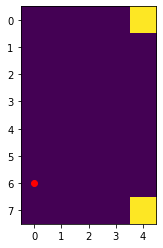

<Figure size 432x288 with 0 Axes>

In [19]:
import random

#Map information
grid = [8, 5]
dirt = [[0, 0, 0, 0, 10],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 10]]
moves = 1000
pos = [6, 0]
terminal = [[0, 4], [7, 4]]

# Random setting
seed = 1  
random.seed(seed)


#Env load
env = World(pos, moves, grid, dirt, terminal)
obs = env.reset()
env.render()

In [20]:
def get_action_value(env, state_values, position, action, gamma):
    env.reset()
    env.position = position
    actions = env._action_space()
    obs, r, d, info  = env.step(actions[action])
    new_position = env.position
    return r + gamma * state_values[new_position[0], new_position[1]]

In [8]:
def init_policy(env):
    policy = np.zeros((env.grid_size[0], env.grid_size[1], len(env._action_space())))
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            actions = env._action_space()
            for i_action in range(len(actions)):
                policy[i][j][i_action] = 0
    return policy
def best_action(policy, i , j): 
    actions = policy[i][j]
    return np.argmax(actions)

In [9]:
def policy_evaluation(env, policy, gamma = 1, theta=0.00001):
    num_iter = 100  # maximum iterations
    # initialize V(s)
    V = np.zeros((env.grid_size[0], env.grid_size[1]))
    for i in range(num_iter):
        delta = 0
        # Compute new state values using the functions defined above.
        new_V = V.copy()
        for i in range(env.grid_size[0]):
            for j in range(env.grid_size[1]):
                action_policy = best_action(policy, i ,j)
                new_V[i, j] = get_action_value(env, V, [i, j], action_policy, gamma)
        delta = max(delta, abs(new_V[i, j] - V[i, j]))         
        V = new_V
        if delta < theta:
            break
    return V

In [10]:
import copy
def policy_improvement(env, V, gamma=1):
    policy = init_policy(env)
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
          # The best action we would take under the current policy
          chosen_a = best_action(policy, i ,j)

          actions = env._action_space()
          A = np.zeros(len(actions))
          for action_i, action in enumerate(actions):
              v = get_action_value(env, V, [i, j], action_i, gamma)
              A[action_i] = v

          action = np.argmax(A)
          # Update the policy
          for action_i in range(len(actions)):
            if action_i == action:
              policy[i][j][action_i] = 1
            else:
              policy[i][j][action_i] = 0
    return policy


def policy_iteration(env, gamma=1, theta=1e-8):
    num_iter = 100 
    policy = init_policy(env)
    for t in range(num_iter):
        V = policy_evaluation(env, policy, gamma, theta)
        new_policy = policy_improvement(env, V)
        
        # stop if the policy is unchanged after an improvement step
        if (new_policy == policy).all():
            break;
        
        policy = copy.copy(new_policy)
        print("iter %4i " % (t + 1))
    return policy, V

In [21]:
import pprint
env.reset()
policy, v = policy_iteration(env)

iter    1 
iter    2 
iter    3 
iter    4 


In [22]:
def opt_policy(env, policy):
    policy_max = np.max(policy, axis=2)
    # print(policy_max)
    y = np.linspace(env.grid_size[0] - 1, 0, env.grid_size[0]) + 0.5
    x = np.linspace(0, env.grid_size[1] - 1, env.grid_size[1]) + 0.5
    X, Y = np.meshgrid(x, y)
    zeros = np.zeros((env.grid_size))
    
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes()
    
    for i_action, action in enumerate(env._action_space()):
        policy_star = np.zeros((env.grid_size[0], env.grid_size[1]))
        for i in reversed(range(env.grid_size[0])):
            for j in reversed(range(env.grid_size[1])):
                if policy[i, j, i_action] == policy_max[i, j]:
                # if policy[i, j, i_action] != 0:
                    policy_star[i, j] = 0.4

        #Plot results
        if action == "U":
            # Vectors point in positive Y-direction
            plt.quiver(X, Y, zeros, policy_star, scale=1, units='xy')
        elif action == "L":
            # Vectors point in negative X-direction
            plt.quiver(X, Y, -policy_star, zeros, scale=1, units='xy')
        elif action == "D":
            # Vectors point in negative Y-direction
            plt.quiver(X, Y, zeros, -policy_star, scale=1, units='xy')
        elif action == "R":
            # Vectors point in positive X-direction
            plt.quiver(X, Y, policy_star, zeros, scale=1, units='xy')
        
    plt.xlim([0, env.grid_size[1]])
    plt.ylim([0, env.grid_size[0]])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.grid()
    plt.show()

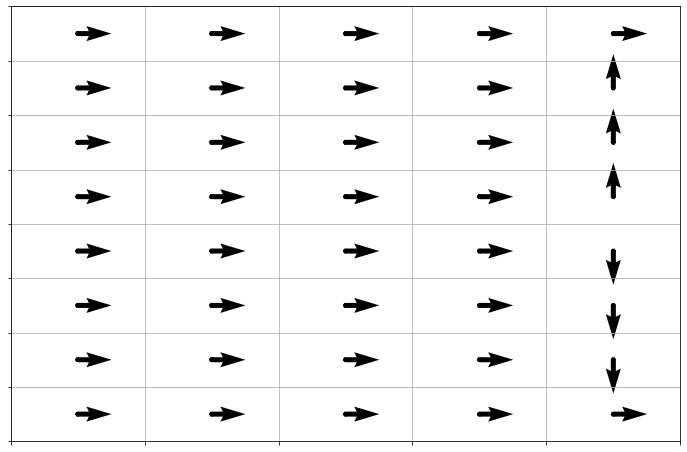

In [23]:
import matplotlib.pyplot as plt
opt_policy(env, policy)

In [64]:
def get_new_state_value(env, V, state, gamma):
    import numpy as np
    if state in env.terminal:
        return 0, 0

    actions = env._action_space()
    v = np.zeros(len(actions))
    
    # Compute all possible options
    for action_i, action in enumerate(actions):
        v[action_i] = get_action_value(env, V, state, action_i, gamma)
    return np.argmax(v), np.max(v)


def value_iteration(env, gamma=1, theta=1e-5):     
    V = np.zeros((env.grid_size[0], env.grid_size[1]))
    last_action = np.zeros((env.grid_size[0], env.grid_size[1]))
    num_iter = 100 
    for t in range(num_iter):
        delta = 0
        for i in range(env.grid_size[0]):
            for j in range(env.grid_size[1]):
                v = V[i][j]
                last_action[i][j], V[i][j] = get_new_state_value(env, V, [i, j], gamma)    
                delta = max(delta,abs(V[i][j]-v))
        if delta < theta:
            break
    
    #update policy
    actions = env._action_space()
    policy = np.zeros((env.grid_size[0], env.grid_size[1], len(actions)))
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            for action_i in range(len(actions)):
                if action_i == last_action[i][j]:
                    policy[i][j][action_i] = 1
                else:
                    policy[i][j][action_i] = 0        
    return policy, V  

In [67]:
env.reset()
policy_vi, V_vi = value_iteration(env)

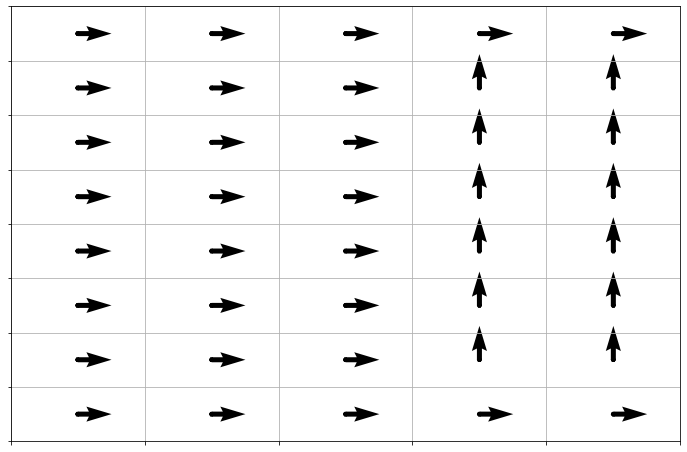

In [68]:
opt_policy(env, policy_vi)